# Comprehensive Guide to Qiskit's `DAGCircuit`

This notebook provides a detailed tutorial on using the `DAGCircuit` (Directed Acyclic Graph Circuit) in Qiskit.

 The `DAGCircuit` is a fundamental data structure for representing quantum circuits internally, primarily used by the Qiskit transpiler for analysis and optimization.

 We will cover:
 1.  Introduction to `DAGCircuit`
 2.  Converting between `QuantumCircuit` and `DAGCircuit`
 3.  Traversing and Analyzing `DAGCircuit` Structure
 4.  Modifying the `DAGCircuit`
 5.  Advanced Operations: Working with Control Flow
 6.  Practical Use Case: Custom `TransformationPass`

In [1]:
# Essential Imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import HGate, XGate
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.dagcircuit import DAGCircuit, DAGOpNode, DAGInNode, DAGOutNode
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.circuit.controlflow import IfElseOp, ForLoopOp, WhileLoopOp

# For drawing DAGs (optional, requires pydot and Graphviz)
from IPython.display import display

## 1. Introduction to `DAGCircuit`

A `DAGCircuit` represents a quantum circuit as a graph where: **Nodes** are operations (`DAGOpNode`), input wires (`DAGInNode`), or output wires (`DAGOutNode`). **Directed Edges** signify the flow of qubits or classical bits (wires) through these operations. An edge from node A to node B means a (qu)bit passes from A's output to B's input. This graph structure is inherently acyclic and is crucial for the Qiskit transpiler to perform optimizations.

In [2]:
# DAGCircuit Attributes
for item in dir(DAGCircuit):
    print(item)

__class__
__delattr__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__module__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
_apply_op_node_back
_check_condition
_clbit_indices
_duration
_edges
_find_successors_by_edge
_has_edge
_in_edges
_in_wires
_is_dag
_num_captured_stretches
_num_declared_stretches
_num_stretches
_out_edges
_out_wires
_qubit_indices
_to_dot
_unit
add_captured_stretch
add_captured_var
add_clbits
add_creg
add_declared_stretch
add_declared_var
add_input_var
add_qreg
add_qubits
ancestors
apply_operation_back
apply_operation_front
bfs_successors
classical_predecessors
classical_successors
clbits
collect_1q_runs
collect_2q_runs
collect_runs
compose
control_flow_op_nodes
copy_empty_like
count_ops
count_ops_longest_path
cregs
depth
descendants
draw
duration
edges
find_bit
front_layer
gate_nodes
global_phase
has_identifier
has_st

## 2.1. `QuantumCircuit` to `DAGCircuit`

The `circuit_to_dag()` function converts a `QuantumCircuit` to a `DAGCircuit`.

Original QuantumCircuit:


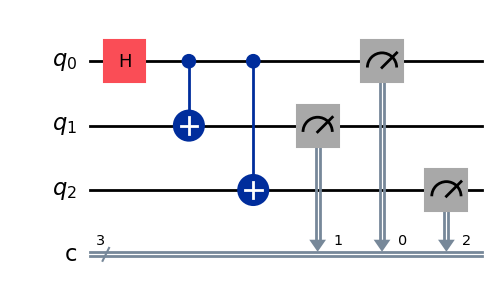

In [3]:
# Create a sample QuantumCircuit
qr = QuantumRegister(3, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr, name="MyGHZState")
qc.h(qr[0])
qc.cx(qr[0], qr[1])
qc.cx(qr[0], qr[2])
qc.measure(qr, cr)

print("Original QuantumCircuit:")
qc.draw(output="mpl")


DAGCircuit created.
DAG Name: MyGHZState
Number of nodes in DAG: 6
Number of op_nodes in DAG: 6
DAG Qubits: [<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>]
DAG Clbits: [<Clbit register=(3, "c"), index=0>, <Clbit register=(3, "c"), index=1>, <Clbit register=(3, "c"), index=2>]


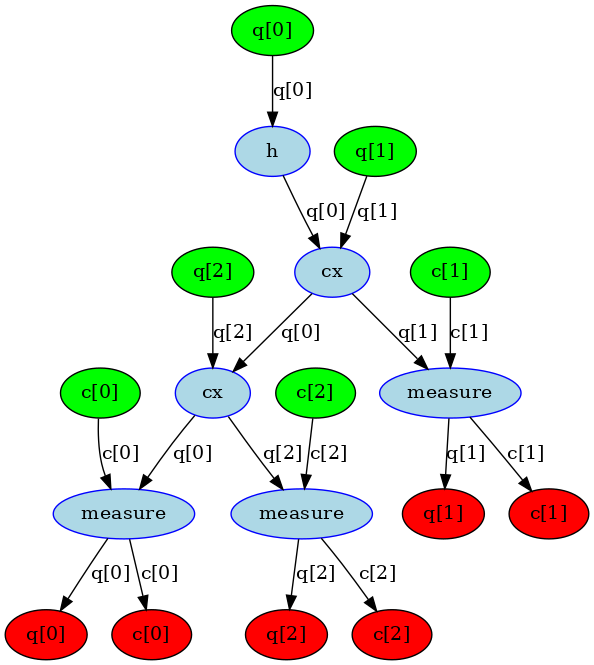

In [4]:
# Convert to DAGCircuit
dag_GHZ = circuit_to_dag(qc)
print("\nDAGCircuit created.")
print(f"DAG Name: {dag_GHZ.name}")
print(
    f"Number of nodes in DAG: {dag_GHZ.size()}"
)  # .size() includes op nodes, input nodes, and output nodes
print(f"Number of op_nodes in DAG: {len(list(dag_GHZ.op_nodes()))}")
print(f"DAG Qubits: {dag_GHZ.qubits}")
print(f"DAG Clbits: {dag_GHZ.clbits}")
display(dag_GHZ.draw(scale=1, style="color"))

## 2.2. `DAGCircuit` to `QuantumCircuit`

Conversely, `dag_to_circuit()` converts a `DAGCircuit` into a `QuantumCircuit`


Reconstructed QuantumCircuit from DAG:


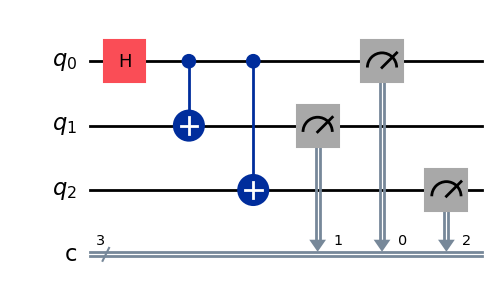

In [5]:
# Convert the DAG back to a QuantumCircuit
reconstructed_qc = dag_to_circuit(dag_GHZ)

# to check if everything is preserved
assert (
    qc.count_ops() == reconstructed_qc.count_ops()
), "Mismatch in operation counts!"

print("\nReconstructed QuantumCircuit from DAG:")
reconstructed_qc.draw(output="mpl")

## 3. Traversing and Analyzing `DAGCircuit` Structure

The `DAGCircuit` object offers a rich API for traversal and analysis.

### 3.1. Iterating over Nodes

You can iterate over different types of nodes:
*   `dag.op_nodes()`: For `DAGOpNode`s (operations).
*   `dag.gate_nodes()`: For `DAGOpNode`s that are `Gate` instances.
*   `dag.named_nodes(*names)`: For `DAGOpNode`s with specific names.
*   `dag.nodes()`: For all nodes (`DAGInNode`, `DAGOutNode`, `DAGOpNode`).
*   `dag.topological_op_nodes()`: `DAGOpNode`s in topological order.
*   `dag.topological_nodes()`: All nodes in topological order.

In [6]:
print("\n--- Iterating over Op Nodes (Topological Order) ---")
for node in dag_GHZ.topological_op_nodes():
    print(
        f"Node ID: {node._node_id}, Name: {node.name}, Type: {type(node.op).__name__}"
    )
    print(f"  Qargs: {node.qargs}")
    if hasattr(node.op, "condition") and node.op.condition:
        print(f"  Condition: {node.op.condition}")

print("\n--- All HGate nodes ---")
for h_node in dag_GHZ.named_nodes("h"):
    print(f"HGate Node ID: {h_node._node_id} on qargs {h_node.qargs}")


--- Iterating over Op Nodes (Topological Order) ---
Node ID: 12, Name: h, Type: _SingletonHGate
  Qargs: (<Qubit register=(3, "q"), index=0>,)
Node ID: 13, Name: cx, Type: _SingletonCXGate
  Qargs: (<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>)
Node ID: 14, Name: cx, Type: _SingletonCXGate
  Qargs: (<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=2>)
Node ID: 15, Name: measure, Type: _SingletonMeasure
  Qargs: (<Qubit register=(3, "q"), index=0>,)
Node ID: 16, Name: measure, Type: _SingletonMeasure
  Qargs: (<Qubit register=(3, "q"), index=1>,)
Node ID: 17, Name: measure, Type: _SingletonMeasure
  Qargs: (<Qubit register=(3, "q"), index=2>,)

--- All HGate nodes ---
HGate Node ID: 12 on qargs (<Qubit register=(3, "q"), index=0>,)


### 3.2. Layers and Depth

*   `dag.layers()`: Yields successive layers of operations that can be executed concurrently.
*   `dag.depth()`: Calculates the depth (longest path of operations).
*   `dag.front_layer()`: Returns the first layer of `DAGOpNode`s.

In [7]:
print(f"\nCircuit depth: {dag_GHZ.depth()}")

print("\n--- Circuit Layers ---")
for i, layer in enumerate(dag_GHZ.layers()):
    print(f"Layer {i}:")
    for node in layer["graph"].op_nodes():  # Each layer is a small DAG itself
        print(
            f"  Node ID: {node._node_id}, Name: {node.name}, Qargs: {node.qargs}"
        )

print("\n--- Front Layer ---")
for node in dag_GHZ.front_layer():
    print(f"Node ID: {node._node_id}, Name: {node.name}, Qargs: {node.qargs}")


Circuit depth: 4

--- Circuit Layers ---
Layer 0:
  Node ID: 12, Name: h, Qargs: (<Qubit register=(3, "q"), index=0>,)
Layer 1:
  Node ID: 12, Name: cx, Qargs: (<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>)
Layer 2:
  Node ID: 12, Name: cx, Qargs: (<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=2>)
  Node ID: 13, Name: measure, Qargs: (<Qubit register=(3, "q"), index=1>,)
Layer 3:
  Node ID: 12, Name: measure, Qargs: (<Qubit register=(3, "q"), index=0>,)
  Node ID: 13, Name: measure, Qargs: (<Qubit register=(3, "q"), index=2>,)

--- Front Layer ---
Node ID: 12, Name: h, Qargs: (<Qubit register=(3, "q"), index=0>,)


### 3.3. Navigating Relationships (Connectivity)

Explore connections between nodes:
*   `dag.successors(node)`, `dag.predecessors(node)`: Immediate successors/predecessors.
*   `dag.ancestors(node)`, `dag.descendants(node)`: All ancestor/descendant nodes.
*   `dag.bfs_successors(node)`: Breadth-first search successors.
*   `dag.nodes_on_wire(wire)`: Nodes connected to a specific wire.

In [8]:
# Getting the Successors and Predecessors of a Node

# Get the first Controlled-Not(cx) gate node
node_example = dag_GHZ.named_nodes("cx")

print(
    f"\n--- Successors and Predecessors of cx (Node ID: {node_example[0]._node_id}) ---"
)
print("Successors:")
for successor in dag_GHZ.successors(node_example[0]):
    node_type_str = type(successor).__name__
    name_str = (
        successor.name
        if isinstance(successor, DAGOpNode)
        else (
            f"In({successor.wire})"
            if isinstance(successor, DAGInNode)
            else (
                f"Out({successor.wire})"
                if isinstance(successor, DAGOutNode)
                else node_type_str
            )
        )
    )
    print(
        f"  Node ID: {successor._node_id}, Type: {node_type_str}, Name/Wire: {name_str}"
    )

print("Predecessors:")
for predecessor in dag_GHZ.predecessors(node_example[0]):
    node_type_str = type(predecessor).__name__
    name_str = (
        predecessor.name
        if isinstance(predecessor, DAGOpNode)
        else (
            f"In({predecessor.wire})"
            if isinstance(predecessor, DAGInNode)
            else (
                f"Out({predecessor.wire})"
                if isinstance(predecessor, DAGOutNode)
                else node_type_str
            )
        )
    )
    print(
        f"  Node ID: {predecessor._node_id}, Type: {node_type_str}, Name/Wire: {name_str}"
    )


--- Successors and Predecessors of cx (Node ID: 13) ---
Successors:
  Node ID: 16, Type: DAGOpNode, Name/Wire: measure
  Node ID: 14, Type: DAGOpNode, Name/Wire: cx
Predecessors:
  Node ID: 2, Type: DAGInNode, Name/Wire: In(<Qubit register=(3, "q"), index=1>)
  Node ID: 12, Type: DAGOpNode, Name/Wire: h


In [9]:
# BFS traversal
start_node = dag_GHZ.named_nodes("h")


# Helper to get a readable name for any node type
def get_node_description(node):
    if isinstance(node, DAGOpNode):
        return f"ID:{node._node_id}, Op({node.name})"
    elif isinstance(node, DAGInNode):
        return f"ID:{node._node_id}, In({node.wire})"
    elif isinstance(node, DAGOutNode):
        return f"ID:{node._node_id}, Out({node.wire})"
    else:
        return f"Node(ID:{node._node_id}, Type:{type(node).__name__})"


print(f"\n--- Start from (Node ID: {start_node[0]._node_id}) ---")
for current_node, successor_node in dag_GHZ.bfs_successors(start_node[0]):
    current_node_desc = get_node_description(current_node)
    print(f"  {current_node_desc}")


--- Start from (Node ID: 12) ---
  ID:12, Op(h)
  ID:13, Op(cx)
  ID:16, Op(measure)
  ID:14, Op(cx)
  ID:17, Op(measure)
  ID:15, Op(measure)


### 3.4. Iterating over Edges
`dag.edges(nodes=None)` yields tuples `(source_node, destination_node, edge_data)`.

`edge_data` is typically the `Bit` (qubit or clbit) the edge carries.

In [10]:
print("\n--- Iterating over Edges ---")
for source_node, dest_node, wire in dag_GHZ.edges():
    s_name = (
        source_node.name
        if isinstance(source_node, DAGOpNode)
        else (
            f"In({source_node.wire})"
            if isinstance(source_node, DAGInNode)
            else (
                f"Out({source_node.wire})"
                if isinstance(source_node, DAGOutNode)
                else type(source_node).__name__
            )
        )
    )
    d_name = (
        dest_node.name
        if isinstance(dest_node, DAGOpNode)
        else (
            f"In({dest_node.wire})"
            if isinstance(dest_node, DAGInNode)
            else (
                f"Out({dest_node.wire})"
                if isinstance(dest_node, DAGOutNode)
                else type(dest_node).__name__
            )
        )
    )
    print(
        f"Edge from Node {source_node._node_id} ({s_name}) to Node {dest_node._node_id} ({d_name}) carrying {wire}"
    )


--- Iterating over Edges ---
Edge from Node 0 (In(<Qubit register=(3, "q"), index=0>)) to Node 12 (h) carrying <Qubit register=(3, "q"), index=0>
Edge from Node 2 (In(<Qubit register=(3, "q"), index=1>)) to Node 13 (cx) carrying <Qubit register=(3, "q"), index=1>
Edge from Node 4 (In(<Qubit register=(3, "q"), index=2>)) to Node 14 (cx) carrying <Qubit register=(3, "q"), index=2>
Edge from Node 6 (In(<Clbit register=(3, "c"), index=0>)) to Node 15 (measure) carrying <Clbit register=(3, "c"), index=0>
Edge from Node 8 (In(<Clbit register=(3, "c"), index=1>)) to Node 16 (measure) carrying <Clbit register=(3, "c"), index=1>
Edge from Node 10 (In(<Clbit register=(3, "c"), index=2>)) to Node 17 (measure) carrying <Clbit register=(3, "c"), index=2>
Edge from Node 12 (h) to Node 13 (cx) carrying <Qubit register=(3, "q"), index=0>
Edge from Node 13 (cx) to Node 16 (measure) carrying <Qubit register=(3, "q"), index=1>
Edge from Node 13 (cx) to Node 14 (cx) carrying <Qubit register=(3, "q"), ind

### 4. Modifying the `DAGCircuit`
`DAGCircuit` objects are mutable, allowing for structural modifications.

Initial DAG for modification:


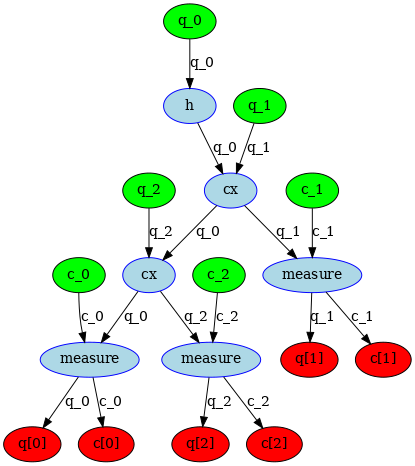

In [11]:
# Create a new DAG for modification examples to keep dag_GHZ pristine

qc_mod = QuantumCircuit.from_instructions(qc.data)

dag_mod = circuit_to_dag(qc_mod)
print("Initial DAG for modification:")
display(dag_mod.draw())

### 4.1. Adding Operations

*   `dag.apply_operation_back(op, qargs, cargs)`: Appends an operation.
*   `dag.apply_operation_front(op, qargs, cargs)`: Prepends an operation.


--- Adding Operations ---
DAG op_node count before adding XGate at back: 6
DAG op_node count after adding XGate at back: 7
DAG after adding XGate:


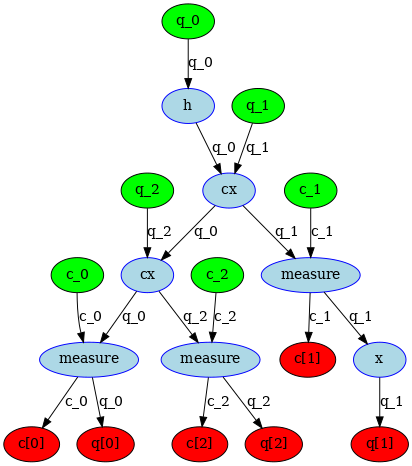

In [12]:
print("\n--- Adding Operations ---")
original_op_node_count = len(list(dag_mod.op_nodes()))
x_gate_new = XGate()
dag_mod.apply_operation_back(
    x_gate_new, qargs=(dag_mod.qubits[1],)
)  # Add X to the second qubit
print(
    f"DAG op_node count before adding XGate at back: {original_op_node_count}"
)
print(
    f"DAG op_node count after adding XGate at back: {len(list(dag_mod.op_nodes()))}"
)
print("DAG after adding XGate:")
display(dag_mod.draw())

### 4.2. Removing Operations
*   `dag.remove_op_node(node)`: Removes a specific `DAGOpNode`.
*   `dag.remove_all_ops_named(opname)`: Removes all nodes with a given operation name.


--- Removing Operations ---
DAG op_node count before removing H-gates: 7
DAG op_node count after removing H-gates: 6
DAG after removing H-gates:


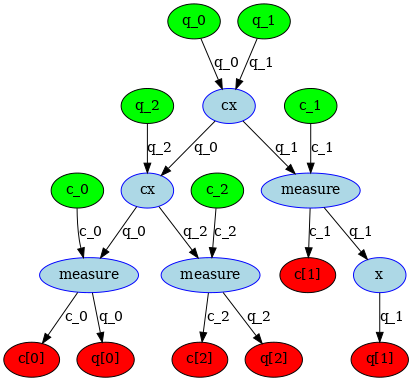

In [13]:
print("\n--- Removing Operations ---")
# Remove all HGate nodes
h_nodes_to_remove = list(
    dag_mod.named_nodes("h")
)  # Materialize list before modification
original_op_node_count = len(list(dag_mod.op_nodes()))
for h_node in h_nodes_to_remove:
    dag_mod.remove_op_node(h_node)
print(f"DAG op_node count before removing H-gates: {original_op_node_count}")
print(
    f"DAG op_node count after removing H-gates: {len(list(dag_mod.op_nodes()))}"
)
print("DAG after removing H-gates:")
display(dag_mod.draw())

### 4.3. Substituting Nodes
*   `dag.substitute_node(node, op, inplace=False)`: Replaces the `Instruction` in a `DAGOpNode`.
*   `dag.substitute_node_with_dag(node, input_dag, wires=None)`: Replaces a `DAGOpNode` with an entire `DAGCircuit`.


--- Substituting Nodes ---
Original DAG for substitution:


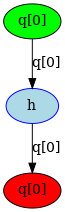

In [14]:
# Re-create a DAG with an H-gate for substitution examples
qc_sub_example = QuantumCircuit(1, name="SubExample")
qc_sub_example.h(0)
dag_sub_example = circuit_to_dag(qc_sub_example)
print("\n--- Substituting Nodes ---")
print("Original DAG for substitution:")
display(dag_sub_example.draw())


DAG after substituting H with X:


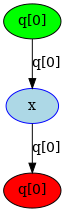

In [15]:
# Example 1: Substitute H with X using substitute_node
h_node_to_replace_simple = dag_sub_example.named_nodes("h")
dag_sub_example.substitute_node(
    h_node_to_replace_simple[0], XGate(), inplace=True
)
print("\nDAG after substituting H with X:")
display(dag_sub_example.draw())


DAG before substituting:


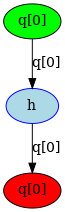


DAG after substituting H-gate with RZ-SX-RZ decomposition:


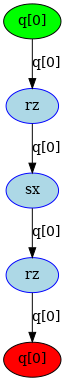

In [16]:
# Example 2: Substitute H with its RZ-SX-RZ decomposition using substitute_node_with_dag
# First, create dag_sub_example to have an H gate again
qc_sub_example_2 = QuantumCircuit(1, name="SubExample2")
qc_sub_example_2.h(0)
dag_sub_example_2 = circuit_to_dag(qc_sub_example_2)
x_node_to_replace_complex = dag_sub_example_2.named_nodes("h")
print("\nDAG before substituting:")
display(dag_sub_example_2.draw())

# Create a DAG for H-gate decomposition: RZ(pi/2) SX RZ(pi/2)
decomp_qc = QuantumCircuit(1, name="h_decomp")
decomp_qc.rz(np.pi / 2, 0)
decomp_qc.sx(0)
decomp_qc.rz(np.pi / 2, 0)
decomp_dag_h_equiv = circuit_to_dag(decomp_qc)

dag_sub_example_2.substitute_node_with_dag(
    x_node_to_replace_complex[0],
    decomp_dag_h_equiv,
)
print("\nDAG after substituting H-gate with RZ-SX-RZ decomposition:")
display(dag_sub_example_2.draw())

## 5. Advanced Operations: Working with Control Flow in `DAGCircuit`

Qiskit supports dynamic circuits with control flow operations like `IfElseOp`, `ForLoopOp`, and `WhileLoopOp`.
In a `DAGCircuit`, these are represented as `DAGOpNode`s where the `op` attribute is an instance of the control flow operation.
The bodies of these operations are `QuantumCircuit` objects.

### 5.1. Accessing Control Flow Parameters

*   **`IfElseOp`**: `node.op.condition`, `node.op.blocks` (tuple of true_body, false_body).
*   **`ForLoopOp`**: `node.op.params` (tuple of indexset, loop_parameter, body), or `node.op.indexset`, `node.op.loop_parameter`, `node.op.blocks` (body).
*   **`WhileLoopOp`**: `node.op.condition`, `node.op.blocks` (body).

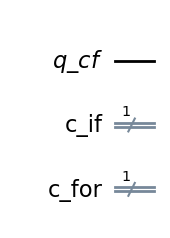

In [17]:
qr_cf = QuantumRegister(1, "q_cf")
cr_if = ClassicalRegister(1, "c_if")
cr_for = ClassicalRegister(1, "c_for")
qc_cf = QuantumCircuit(qr_cf, cr_if, cr_for)
qc_cf.draw("mpl")

In [18]:
# IfElseOp example
with qc_cf.if_test((cr_if, 0)) as else_block_false:  # if cr_if == 0
    qc_cf.x(qr_cf)  # True body
if else_block_false:  # This defines the else block
    qc_cf.h(qr_cf)  # False body

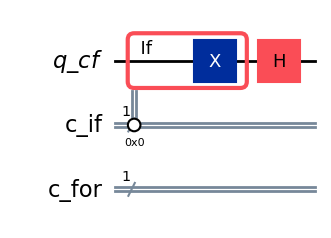

In [19]:
qc_cf.draw("mpl")

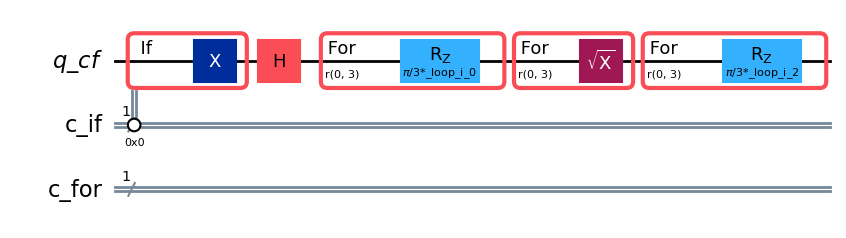

In [20]:
# ForLoopOp example
# The loop parameter 'idx' is implicitly created by the context manager
with qc_cf.for_loop(range(3)) as idx:
    qc_cf.rz(idx * np.pi / 3, qr_cf)  # Body of the for loop

with qc_cf.for_loop(range(3)) as idx:
    qc_cf.sx(0)

with qc_cf.for_loop(range(3)) as idx:
    qc_cf.rz(idx * np.pi / 3, qr_cf)


qc_cf.draw("mpl")

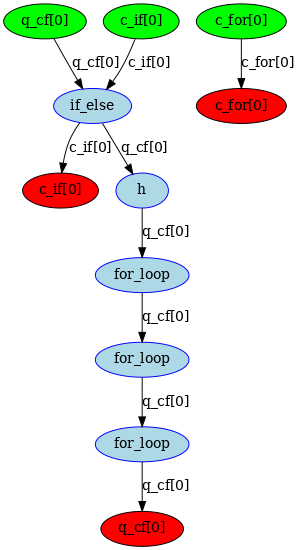

In [21]:
dag_with_cf = circuit_to_dag(qc_cf)
display(dag_with_cf.draw())


--- Inspecting Control Flow Nodes in DAG ---
Found IfElseOp (Node ID: 6)
  Condition: (ClassicalRegister(1, 'c_if'), 0)


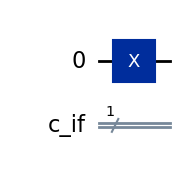

  True body (1 ops):
None
Found ForLoopOp (Node ID: 8)
  Indexset: range(0, 3)
  Loop Parameter: _loop_i_0 (name: _loop_i_0)


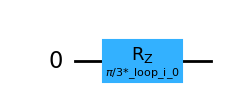

  Body (1 ops):
None
Found ForLoopOp (Node ID: 9)
  Indexset: range(0, 3)
  Loop Parameter: None (name: None)


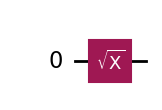

  Body (1 ops):
None
Found ForLoopOp (Node ID: 10)
  Indexset: range(0, 3)
  Loop Parameter: _loop_i_2 (name: _loop_i_2)


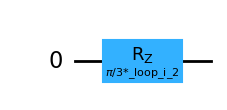

  Body (1 ops):
None


In [22]:
print("\n--- Inspecting Control Flow Nodes in DAG ---")
for node in dag_with_cf.op_nodes():
    if isinstance(node.op, IfElseOp):
        print(f"Found IfElseOp (Node ID: {node._node_id})")
        print(f"  Condition: {node.op.condition}")
        true_body_qc = node.op.blocks
        print(
            f"  True body ({len(true_body_qc)} ops):\n{display(true_body_qc[0].draw("mpl"))}"
        )
        if len(node.op.blocks) > 1 and node.op.blocks:
            false_body_qc = node.op.blocks
            print(
                f"  False body ({len(false_body_qc)} ops):\n{display(false_body_qc.draw("mpl"))}"
            )
    elif isinstance(node.op, ForLoopOp):
        # ForLoopOp.params is a tuple: (indexset, loop_parameter, body)
        indexset, loop_param, body_qc = node.op.params
        print(f"Found ForLoopOp (Node ID: {node._node_id})")
        print(f"  Indexset: {indexset}")
        print(
            f"  Loop Parameter: {loop_param} (name: {loop_param.name if loop_param else 'None'})"
        )
        print(f"  Body ({len(body_qc)} ops):\n{display(body_qc.draw("mpl"))}")
    elif isinstance(
        node.op, WhileLoopOp
    ):  # Example for WhileLoopOp would be analogous
        print(f"Found WhileLoopOp (Node ID: {node._node_id})")

## 6. Practical Use Case: Custom `TransformationPass`

Custom transpiler passes allow for bespoke circuit optimizations by directly manipulating the `DAGCircuit`.
A custom pass is created by subclassing `TransformationPass` and implementing the `run(self, dag: DAGCircuit) -> DAGCircuit` method.

### 6.1. Example: Custom Pass - `ReplaceHWithX`
This pass replaces all Hadamard (H) gates with Pauli-X gates. (Note: This is for demonstration and is not a semantically correct transformation for actual quantum computation.)


--- Custom Transformation Pass Example ---
Initial QuantumCircuit for pass test:


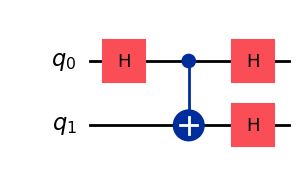


Initial DAGCircuit:


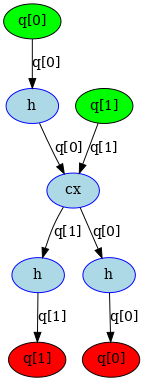

Running ReplaceHWithX pass on DAG: PassTestCircuit
  Found 3 H-gates to replace.
  Replacing H-gate (Node ID: 4) with X-gate.
  Replacing H-gate (Node ID: 6) with X-gate.
  Replacing H-gate (Node ID: 7) with X-gate.

DAGCircuit after ReplaceHWithX pass:


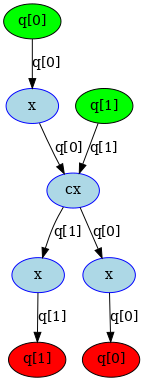


Final QuantumCircuit after pass:


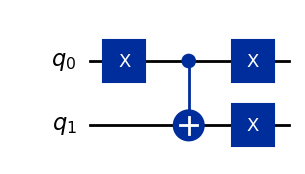


Initial H-gate count: 3
Final H-gate count: 0
Final X-gate count: 3
Custom pass executed and verified successfully.


In [23]:
class ReplaceHWithX(TransformationPass):
    """
    A transformation pass that replaces all HGate instances in a DAGCircuit
    with XGate instances.
    """

    def run(self, dag: DAGCircuit) -> DAGCircuit:
        """
        Run the ReplaceHWithX pass on `dag`.

        Args:
            dag: The input DAGCircuit.

        Returns:
            The modified DAGCircuit with H gates replaced by X gates.
            The modification is done in-place on the input DAG.
        """
        print(f"Running ReplaceHWithX pass on DAG: {dag.name}")
        h_nodes_to_replace = [
            node for node in dag.op_nodes() if isinstance(node.op, HGate)
        ]
        print(f"  Found {len(h_nodes_to_replace)} H-gates to replace.")

        for h_node in h_nodes_to_replace:
            print(
                f"  Replacing H-gate (Node ID: {h_node._node_id}) with X-gate."
            )
            dag.substitute_node(h_node, XGate(), inplace=True)

        return dag


# %%
# --- Example Usage of Custom Pass ---
qc_initial_pass_test = QuantumCircuit(2, name="PassTestCircuit")
qc_initial_pass_test.h(0)
qc_initial_pass_test.cx(0, 1)
qc_initial_pass_test.h(1)
qc_initial_pass_test.h(0)  # Another H on q0

print("\n--- Custom Transformation Pass Example ---")
print("Initial QuantumCircuit for pass test:")
display(qc_initial_pass_test.draw(output="mpl"))

# Convert to DAGCircuit
dag_initial_pass_test = circuit_to_dag(qc_initial_pass_test)
print("\nInitial DAGCircuit:")
try:
    display(dag_initial_pass_test.draw())
except Exception:
    print("DAG drawing failed or not in Jupyter environment.")

pass_replace = ReplaceHWithX()
modified_dag_pass_test = pass_replace.run(dag_initial_pass_test)

print("\nDAGCircuit after ReplaceHWithX pass:")
try:
    display(modified_dag_pass_test.draw())
except Exception:
    print("DAG drawing failed or not in Jupyter environment.")

# Convert the modified DAG back to a QuantumCircuit to verify
final_qc_pass_test = dag_to_circuit(modified_dag_pass_test)
print("\nFinal QuantumCircuit after pass:")
display(final_qc_pass_test.draw(output="mpl"))

# Verify the H gates are gone and X gates are present
initial_h_count = qc_initial_pass_test.count_ops().get("h", 0)
final_h_count = final_qc_pass_test.count_ops().get("h", 0)
final_x_count = final_qc_pass_test.count_ops().get("x", 0)

print(f"\nInitial H-gate count: {initial_h_count}")
print(f"Final H-gate count: {final_h_count}")
print(f"Final X-gate count: {final_x_count}")

assert final_h_count == 0, "H-gates were not removed!"
assert (
    final_x_count == initial_h_count
), "X-gate count does not match original H-gate count!"
print("Custom pass executed and verified successfully.")